# 🚴 Citi Bike

This project includes data from 2019, 2020, and January-April of 2021, downloaded from here: https://s3.amazonaws.com/tripdata/index.html 

| Column | Definition |
|:---|:---|
| **tripduration** | Duration in Seconds |
| **starttime** | Start Time and Date |
| **stoptime** | Stop Time and Date |
| **start station id** | ID of Start Station |
| **start station name** | Name of Start Station|
| **start station latitude** | Latitude of start station |
| **start station longitude** | Longitude of start station |
| **end station id** | ID of End Station |
| **end station name** | Name of End Station |
| **end station latitude** | Latitude of End station |
| **end station longitude** | Longitude of End station |
| **bikeid** | ID of Bicycle |
| **usertype** | Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member |
| **gender** | 0=unknown; 1=male; 2=female |
| **birthyear** | Year of Birth |


# 📑 Importing & Merging

In [66]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly as pl
import plotly.express as px
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [67]:
# Importing datasets
dfs = []

dtype = {'tripduration': 'int32', 'start station id': 'float32', 'start station name': 'object', 
         'start station latitude': 'float32', 'start station longitude': 'float32',
        'end station id': 'float32', 'end station name': 'object',
        'end station latitude': 'float32', 'end station longitude': 'float32',
        'bikeid': 'int32', 'usertype': 'category', 'birth year': 'int16', 'gender': 'int8'}
parse_dates = ['starttime', 'stoptime']

for directory, sub, files in os.walk(os.getcwd()):
    for f in files:
        if f.endswith('.csv'):
            dfs.append(pd.read_csv(f, dtype=dtype, parse_dates=parse_dates, keep_default_na=True))

In [68]:
# Merging the list of dataframes into one dataframe
df = pd.concat(dfs, ignore_index=True)

In [69]:
# Creating a column called 'index'
df = df.reset_index()

# 🧭 Exploring & Pre-Processing

In [70]:
df.describe()

,index,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,2.094501e+07,2.094501e+07,2.094483e+07,2.094501e+07,2.094501e+07,2.094483e+07,2.094501e+07,2.094501e+07,2.094501e+07,2.094501e+07,2.094501e+07
mean,1.047250e+07,9.888089e+02,1.694271e+03,4.073690e+01,-7.398415e+01,1.685378e+03,4.073653e+01,-7.398427e+01,2.989206e+04,1.980198e+03,1.161028e+00
std,6.046303e+06,1.072308e+04,1.480462e+03,3.021452e-02,2.148663e-02,1.480193e+03,3.259559e-02,3.140252e-02,7.682836e+03,1.211329e+01,5.413831e-01
min,0.000000e+00,6.100000e+01,7.200000e+01,4.065540e+01,-7.408364e+01,7.200000e+01,0.000000e+00,-7.408364e+01,1.452900e+04,1.857000e+03,0.000000e+00
25%,5.236252e+06,3.620000e+02,3.850000e+02,4.071755e+01,-7.399601e+01,3.820000e+02,4.071755e+01,-7.399662e+01,2.546800e+04,1.970000e+03,1.000000e+00
50%,1.047250e+07,6.150000e+02,5.170000e+02,4.073705e+01,-7.398584e+01,5.160000e+02,4.073653e+01,-7.398627e+01,3.105200e+04,1.983000e+03,1.000000e+00
75%,1.570876e+07,1.082000e+03,3.295000e+03,4.075715e+01,-7.397188e+01,3.294000e+03,4.075660e+01,-7.397208e+01,3.515600e+04,1.990000e+03,1.000000e+00
max,2.094501e+07,3.812666e+06,3.911000e+03,4.086900e+01,-7.387800e+01,4.282000e+03,4.086900e+01,0.000000e+00,5.529800e+04,2.004000e+03,2.000000e+00


Certain columns will need cleaning:
- Minimum 'birth year' is 1857
- Max 'trip duration' is 3812666 seconds, which is over 1,000 hours
- There are potentially nulls in the dataframe

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20945009 entries, 0 to 20945008
Data columns (total 16 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   index                    int64         
 1   tripduration             int32         
 2   starttime                datetime64[ns]
 3   stoptime                 datetime64[ns]
 4   start station id         float32       
 5   start station name       object        
 6   start station latitude   float32       
 7   start station longitude  float32       
 8   end station id           float32       
 9   end station name         object        
 10  end station latitude     float32       
 11  end station longitude    float32       
 12  bikeid                   int32         
 13  usertype                 category      
 14  birth year               int16         
 15  gender                   int8          
dtypes: category(1), datetime64[ns](2), float32(6), int16(1), int32(2), int

# 🧹 Cleaning

## 😶 Null Values

In [72]:
# Are there nulls in the dataframe?
df.isnull().values.any()

True

In [73]:
# Which columns have nulls, and how many?
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

start station id      180
start station name    180
end station id        180
end station name      180
dtype: int64

In [74]:
# What does this look like
df[df['start station id'].isnull()]

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
44726,44726,1949,2019-02-02 16:44:18.768,2019-02-02 17:16:48.689,NaN,NaN,40.841999,-73.880997,NaN,NaN,40.856998,-73.889999,34481,Subscriber,1987,1
45855,45855,220,2019-02-02 17:22:12.290,2019-02-02 17:25:53.089,NaN,NaN,40.856998,-73.889999,NaN,NaN,40.856998,-73.889999,34481,Subscriber,1987,1
46234,46234,413,2019-02-02 17:38:30.089,2019-02-02 17:45:23.991,NaN,NaN,40.862999,-73.889999,NaN,NaN,40.860001,-73.889999,34550,Subscriber,1987,1
70163,70163,5651,2019-02-03 15:35:24.989,2019-02-03 17:09:36.271,NaN,NaN,40.856998,-73.880997,NaN,NaN,40.856998,-73.880997,34550,Subscriber,1969,1
81579,81579,566,2019-02-03 21:50:12.087,2019-02-03 21:59:38.091,NaN,NaN,40.856998,-73.880997,NaN,NaN,40.862999,-73.889999,34550,Subscriber,1994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20606628,20606628,189,2019-01-21 15:52:59.816,2019-01-21 15:56:09.013,NaN,NaN,40.862999,-73.889999,NaN,NaN,40.862999,-73.889999,34550,Subscriber,1986,1
20765297,20765297,759,2019-01-26 22:37:57.027,2019-01-26 22:50:36.428,NaN,NaN,40.854000,-73.892998,NaN,NaN,40.851002,-73.902000,34892,Subscriber,1985,0
20765855,20765855,1659,2019-01-26 23:40:03.030,2019-01-27 00:07:42.226,NaN,NaN,40.851002,-73.899002,NaN,NaN,40.854000,-73.911003,34892,Subscriber,1985,0
20827092,20827092,621,2019-01-28 19:31:38.591,2019-01-28 19:41:59.687,NaN,NaN,40.854000,-73.892998,NaN,NaN,40.841999,-73.880997,34481,Subscriber,1975,1


After looking at the table above, it seems like a lot of the 'start locations' and 'end locations' might be close together, and some even repeat. To see if that's correct, I wanted to see the unique points of latitude and longitude for beginning stations and ending stations.

In [75]:
# Unique start station latitude coordinates
df[df['start station id'].isnull()]['start station latitude'].unique()

array([40.842, 40.857, 40.863, 40.866, 40.845, 40.86 , 40.851, 40.848,
       40.854, 40.869], dtype=float32)

In [76]:
# Unique start station longitude coordinates
df[df['start station id'].isnull()]['start station longitude'].unique()

array([-73.881, -73.89 , -73.884, -73.902, -73.887, -73.905, -73.893,
       -73.896, -73.899, -73.911, -73.908, -73.878, -73.914],
      dtype=float32)

Although there are 180 rows with null values, there are only a handful of coordinates. This means that certain 'start locations' repeat. 

In [77]:
# Unique end station latitude coordinates
df[df['end station id'].isnull()]['end station latitude'].unique()

array([40.857, 40.86 , 40.863, 40.866, 40.848, 40.851, 40.845, 40.854,
       40.842, 40.869], dtype=float32)

In [78]:
# Unique end station lingitude coordinates
df[df['end station id'].isnull()]['end station longitude'].unique()

array([-73.89 , -73.881, -73.884, -73.887, -73.905, -73.902, -73.896,
       -73.893, -73.899, -73.908, -73.911, -73.878, -73.914],
      dtype=float32)

Likewise, there are also a handful of 'end stations', meaning they must repeat as well. 

In order to better understand the null values, I decided to map them out, to see where they're located.

As can be seen below, all the rows with the null values are located in the Bronx. And altough many of the beginning and ending coordinates are the same, the index numbers are different, as if the bikes "replaced" each other at the exact coordinates. For this reason, all null rows were removed, as this seems to be an error.

In [79]:
# Mapping the start coordinates
nulldf_start = df[df['start station id'].isnull()][['start station latitude','start station longitude','index']].drop_duplicates()
nullfig_start = px.scatter_mapbox(nulldf_start,
                          lat='start station latitude',
                          lon='start station longitude',
                          color='index',
                          color_continuous_scale='bluered',
                          zoom=12,
                          title='Start Station Coordinates'
)

pl.offline.iplot(nullfig_start.update_layout(mapbox_style="open-street-map"), filename='start_stations.png')

In [80]:
# Mapping the end coordinates
nulldf_end = df[df['end station id'].isnull()][['end station latitude','end station longitude','index']].drop_duplicates()
nullfig_end = px.scatter_mapbox(nulldf_end,
                          lat='end station latitude',
                          lon='end station longitude',
                          color='index',
                          color_continuous_scale='bluered',
                          zoom=12,
                          title='End Station Coordinates'
)

pl.offline.iplot(nullfig_end.update_layout(mapbox_style="open-street-map"), filename='end_stations.png')

Since the null values seem like errors, and are not located near any known stations, I decided to remove them.

In [81]:
# Remove all rows with null values
df_nonull = df.dropna(how='any',axis=0)

In [82]:
# Check if there are remaining nulls
df_nonull.isnull().values.any()

False

## 📅 Birth Year

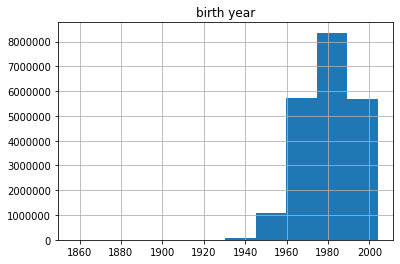

In [83]:
# Get histogram of the birth years
df_nonull[['birth year']].hist()
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

<AxesSubplot:>

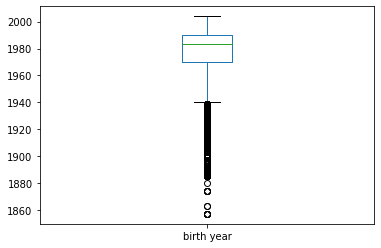

In [84]:
df_nonull[['birth year']].plot(kind='box')

We can see that 'birth year' goes as far back as 1860. These are clearly errors. I decided that 70 is a reasonable cutoff age.

In [85]:
# Drop rows with riders over the age of 70
max_age = 70
df_nonull_cleanage = df_nonull.drop(
    (df_nonull[(df_nonull['starttime'].dt.year==2019) & (df_nonull['birth year']<(2019-max_age))].index) |\
    (df_nonull[(df_nonull['starttime'].dt.year==2020) & (df_nonull['birth year']<(2020-max_age))].index) |\
    (df_nonull[(df_nonull['starttime'].dt.year==2021) & (df_nonull['birth year']<(2021-max_age))].index)
)

<ipython-input-85-9988861875fd>:4: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead

<ipython-input-85-9988861875fd>:4: FutureWarning:

Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead



<AxesSubplot:>

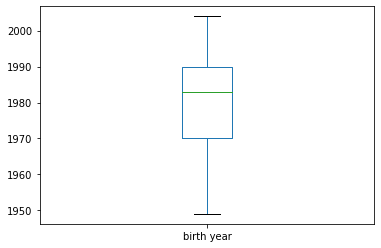

In [86]:
df_nonull_cleanage[['birth year']].plot(kind='box')

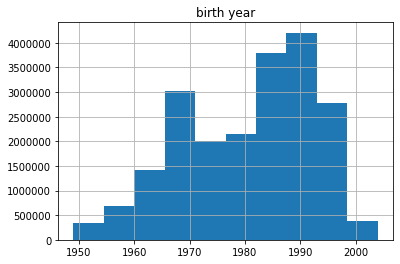

In [87]:
# Updated histogram of birth years 
df_nonull_cleanage[['birth year']].hist()
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [88]:
# Delete previous dataframe to save memory
del df_nonull

In [89]:
import gc;gc.collect()

16198

## ⌛ Trip Duration

In [90]:
# Convert 'trip duration' from seconds to minutes
df_nonull_cleanage['tripminutes'] = df_nonull_cleanage['tripduration']/60

TypeError: 'str' object is not callable

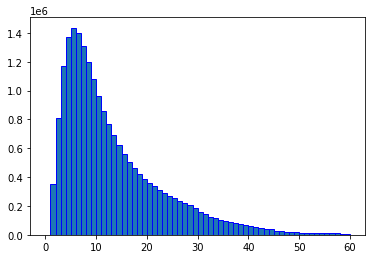

In [92]:
# Visualize histogram of 'trip minutes'
plt.hist((df_nonull_cleanage['tripminutes']), log=False, bins=range(0,61),edgecolor='b')
plt.xlabel('minutes')
plt.ylabel('count')

In [93]:
# Define 1st and 3th quartiles of 'tripminutes'
Q1_minutes = df_nonull_cleanage['tripminutes'].quantile(0.25)
Q3_minutes = df_nonull_cleanage['tripminutes'].quantile(0.75)

# Calculate IQR
IQR_minutes = Q3_minutes - Q1_minutes

In [94]:
# Removing the outliers
minutes_lowerrange = (Q1_minutes - (1.5 * IQR_minutes))
minutes_upperrange = (Q3_minutes + (1.5 * IQR_minutes))

In [95]:
# Creating a dataframe without the outliers
df_clean = df_nonull_cleanage[((df_nonull_cleanage['tripminutes'] <= minutes_upperrange) & (df_nonull_cleanage['tripminutes'] >= minutes_lowerrange))]

In [96]:
# Delete previous dataframe to save memory
del df_nonull_cleanage

In [97]:
gc.collect()

13239

## 💵 Revenue

In [98]:
# Convert 'Customer' = 1
# Convert 'Subscriber' = 2
def user(x):
    if x == 'Customer':
        return 1
    elif x == 'Subscriber':
        return 2
    else:
        return 0

df_clean['usertype'] = df_clean['usertype'].apply(user)

In [99]:
df_clean['usertype'].dtypes

CategoricalDtype(categories=[1, 2], ordered=False)

In [100]:
# Create a function to calculate the revenue for each ride
def revenue(row):
    if (row['usertype'] == 1 and round(row['tripminutes'],2) <= 30.0):
        return 3.50
    elif (row['usertype'] == 2 and round(row['tripminutes'],2) <= 45.0):
        return 0.00
    elif (row['usertype'] == 1 and round(row['tripminutes'],2) > 30.0):
        return 3.50 + (round(row['tripminutes'], 2) * 0.18)
    elif (row['usertype'] == 2 and round(row['tripminutes'],2) > 45.0):
        return round(row['tripminutes'],2) * 0.12
    else:
        return  -1

In [101]:
# Apply the function to create a new column
df_clean['trip_revenue'] = df_clean[['usertype','tripminutes']].parallel_apply(revenue, axis=1)

In [102]:
df_clean['trip_revenue'].min()

0.0

In [103]:
gc.collect()

30

# 📊 Graphing

## 🧮 Demographics

In [104]:
# Create columns with year
df_clean['start_year'] = df_clean['starttime'].dt.year
df_clean['end_year'] = df_clean['stoptime'].dt.year

In [105]:
df_clean.columns

Index(['index', 'tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'tripminutes', 'trip_revenue', 'start_year',
       'end_year'],
      dtype='object')

In [106]:
# Create an 'age' column
df_clean['age'] = (df_clean['start_year'] - df_clean['birth year'])

In [107]:
# Create a new dataframe with average age by gender by user
user_age = df_clean.groupby(['usertype','gender']).agg({'age': ['mean']}).reset_index()
user_age.columns = user_age.columns.get_level_values(0)

In [108]:
# Convert back to 'Customer' = 1
# Convert back to 'Subscriber' = 2
def userback(x):
    if x == 1:
        return 'Customer'
    elif x == 2:
        return 'Subscriber'
    else:
        return 0

user_age['usertype'] = user_age['usertype'].apply(userback)

In [109]:
# Convert gender to strings
def gender(x):
    if x == 0:
        return 'Unknown'
    elif x == 1:
        return 'Male'
    elif x == 2:
        return 'Female'
    else:
        return 0

user_age['gender'] = user_age['gender'].apply(gender)

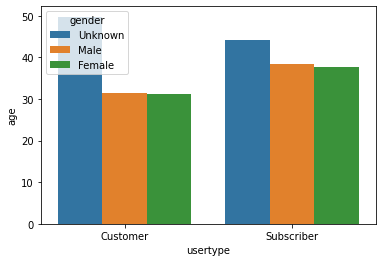

In [110]:
# Plot bar chart with average age by gender and user
plt.figure()
sns.barplot(
    x = 'usertype',
    y = 'age',
    hue = 'gender',
    data = user_age
)
plt.show()

In [111]:
# Find revenue by usertype and gender
total_dem_rev = df_clean.groupby(['usertype','gender']).agg({'trip_revenue': ['sum']}).reset_index()
total_dem_rev.columns = total_dem_rev.columns.get_level_values(0)
total_dem_rev['usertype'] = total_dem_rev['usertype'].apply(userback)
total_dem_rev['gender'] = total_dem_rev['gender'].apply(gender)

In [112]:
total_dem_rev

,usertype,gender,trip_revenue
0,Customer,Unknown,4.526317e+06
1,Customer,Male,3.744347e+06
2,Customer,Female,2.082743e+06
3,Subscriber,Unknown,0.000000e+00
4,Subscriber,Male,0.000000e+00
5,Subscriber,Female,0.000000e+00


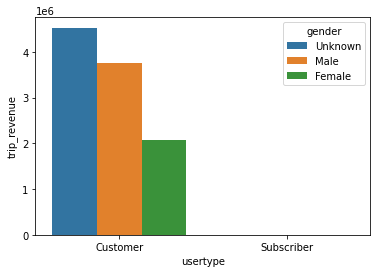

In [113]:
plt.figure()
sns.barplot(
    x = 'usertype',
    y = 'trip_revenue',
    hue = 'gender',
    data = total_dem_rev
)
plt.show()

After removing outliers, Citi Bike makes no revenue off of Subscriber trips, meaning that they are 45 minutes or below. Note that Subscribers pay $15/month, they do not ride for free. This is the revenue from the trips.

In [114]:
# Find average duration of trips by usertype and gender
avg_minutes = df_clean.groupby(['usertype','gender']).agg({'tripminutes': ['mean']}).reset_index()
avg_minutes.columns = avg_minutes.columns.get_level_values(0)
avg_minutes['usertype'] = avg_minutes['usertype'].apply(userback)
avg_minutes['gender'] = avg_minutes['gender'].apply(gender)

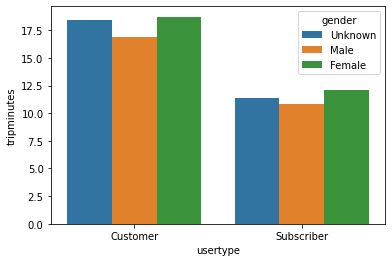

In [115]:
plt.figure()
sns.barplot(
    x = 'usertype',
    y = 'tripminutes',
    hue = 'gender',
    data = avg_minutes
)
plt.show()

We see that Subscribers' average trips are shorter than Customers' trips.

In [116]:
gc.collect()

11000

## 🚲 Incentivizing Station Returns

Citi Bike has costs associated wtih reallocating bikes to popular stations, to ensure that there are enough bikes for users to ride. The below section looks at whether or not Citi Bike could potentially incentivize its users to return bikes to specific stations, rather than paying a third party to do so.

Breakdown:
- Flow rate per station: number of bikes going in and out of a station
 - Group trips by station id by year
 - Calculate flow = count(is end station) - count(is start station)
 - New dataframe of: station id | flow rate
- Graph the stations with extreme flow rates

In [117]:
# Create dataframe for flow out
grouped_start = df_clean.groupby(['start station id', 'start_year']).agg({'bikeid': ['count'], 'start station latitude':['mean'],'start station longitude':['mean']})
grouped_start = grouped_start.reset_index()

In [118]:
grouped_start.head()

,start station id,start_year,bikeid,start station latitude,start station longitude
,,,count,mean,mean
0,72.0,2019,42745,40.767273,-73.993927
1,79.0,2019,25668,40.719116,-74.006668
2,82.0,2019,13102,40.711174,-74.000168
3,83.0,2019,16761,40.683826,-73.976326
4,116.0,2019,47140,40.741776,-74.001495


In [119]:
# Create dataframe for flow in
grouped_end = df_clean.groupby(['end station id', 'end_year']).agg({'bikeid':['count']})
grouped_end = grouped_end.reset_index()

In [120]:
grouped_end.head()

,end station id,end_year,bikeid
,,,count
0,72.0,2019,42512
1,79.0,2019,25984
2,82.0,2019,13106
3,83.0,2019,18807
4,116.0,2019,47646


In [121]:
# Merge the two and flatten the headers
grouped = pd.merge(grouped_start,grouped_end,
    left_on=['start station id','start_year'], right_on=['end station id','end_year'], how='left')

grouped.columns = grouped.columns.get_level_values(0)

In [122]:
# See what the new dataframe looks like
grouped.head()

,start station id,start_year,bikeid_x,start station latitude,start station longitude,end station id,end_year,bikeid_y
0,72.0,2019,42745,40.767273,-73.993927,72.0,2019,42512
1,79.0,2019,25668,40.719116,-74.006668,79.0,2019,25984
2,82.0,2019,13102,40.711174,-74.000168,82.0,2019,13106
3,83.0,2019,16761,40.683826,-73.976326,83.0,2019,18807
4,116.0,2019,47140,40.741776,-74.001495,116.0,2019,47646


In [123]:
# Remove the unnecessary columns
grouped = grouped.drop(columns=['end station id','end_year'])

In [124]:
# Rename the columns
grouped = grouped.rename(columns={
'start station id': 'station_id',
'start_year': 'year',
'bikeid_x': 'flow_out',
'bikeid_y': 'flow_in',
'start station latitude': 'lat',
'start station longitude': 'lon'
    })

In [125]:
# Create a column to calculate the flow rate
grouped['flow_rate'] = grouped['flow_in'] - grouped['flow_out']

In [126]:
# Check the new dataframe
grouped

,station_id,year,flow_out,lat,lon,flow_in,flow_rate
0,72.0,2019,42745,40.767273,-73.993927,42512,-233
1,79.0,2019,25668,40.719116,-74.006668,25984,316
2,82.0,2019,13102,40.711174,-74.000168,13106,4
3,83.0,2019,16761,40.683826,-73.976326,18807,2046
4,116.0,2019,47140,40.741776,-74.001495,47646,506
...,...,...,...,...,...,...,...
1034,3907.0,2019,49,40.701118,-73.930389,31,-18
1035,3908.0,2019,1438,40.704632,-74.015068,1474,36
1036,3909.0,2019,5,40.704079,-73.904083,5,0
1037,3910.0,2019,26,40.709698,-73.907860,29,3


In [127]:
grouped_index = grouped.reset_index()

In [128]:
grouped_index = grouped_index.sort_values(by='flow_rate')

In [129]:
gc.collect()

150

Text(0.5, 1.0, 'Flow Rate for Every Station')

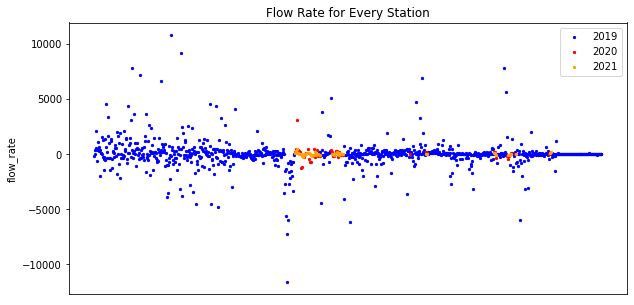

In [130]:
# Plot a scatter plot to see how far the flow rate is from 0
fig,ax=plt.subplots(figsize=(10, 5))
grouped_index[grouped_index['year']==2019].plot(kind='scatter', y='flow_rate', x='index', marker='.', label='2019', ax=ax, color='blue')
grouped_index[grouped_index['year']==2020].plot(kind='scatter', y='flow_rate', x='index', marker='.', label='2020', ax=ax, color='red')
grouped_index[grouped_index['year']==2021].plot(kind='scatter', y='flow_rate', x='index', marker='.', label='2021', ax=ax, color='orange')
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
plt.xlabel=('Stations')
plt.title('Flow Rate for Every Station')

As expected, most stations' flow rates are near 0, meaning that the number of bikes coming in and out of each station are more or less the same.

However, there are some stations where the flow rate does not equal 0. This means that Citi Bike is moving/re-allocating bikes. I want to focus on the stations farthest away from 0.

In [131]:
# Get stations where the flow rate is greater than 3,000 or less than -3,000
the_flow = 3000
bad_flow = grouped[(grouped['flow_rate'] > the_flow) | (grouped['flow_rate'] < the_flow*-1)][grouped['year']==2019]

<ipython-input-131-b828c559416b>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [132]:
bad_flow.head()

,station_id,year,flow_out,lat,lon,flow_in,flow_rate
24,217.0,2019,31185,40.702770,-73.993835,35662,4477
28,229.0,2019,74400,40.727436,-73.993790,77730,3330
69,293.0,2019,90288,40.730206,-73.991028,94601,4313
76,303.0,2019,46106,40.723629,-73.999496,49220,3114
77,304.0,2019,40322,40.704632,-74.013618,48095,7773


In [133]:
gc.collect()

45

In [134]:
figflow = px.scatter_mapbox(bad_flow,
                            lat='lat',
                            lon='lon',
                            color='flow_rate',
                            color_continuous_scale='IceFire',
                            size=([10]*len(bad_flow['station_id'])),
                            size_max=10,
                            zoom=11,
)

plotly.offline.iplot(figflow.update_layout(mapbox_style="open-street-map"), filename='flow.png')

# ✨ Insights

Citi Bike has a problem that bike stations are over and under allocated accross the city. As a result, Citi has to pay to reallocate bikes across stations regularly using box trucks and vans, which are a major cost. To save money, Citi can incentivize the riders to do the reallocation for them. Using a 'flow rate' metric, we can identify the under and over allocated stations. The incentive is simply to promote bike drop off at under allocated stations, and promote bike pick up at over allocated stations.

The map above includes stations that are over-allocated, represented by the red dots, and under-allocated, represented by the blue dots.

Assuming Citi Bike has more granular information on where a user normally picks up and drops off a bike, if there are two nearby points on the map with opposite colors, Citi Bike can offer a promotion to a user to either:
- Pick up a bike from a nearby red station instead of a blue one
- Return a bike to a nearby blue station instead of a red one
- A combination of the two

The promotion should first be offered to Customers who are of Unknown gender, since they make up the most revenue, and this would incentivize them to ride more. If there still aren't enough bikes being reallocated in the popular stations,  Male Customers should be offered the promotion, and lastly Female Customers.

This promotion should not be offered to Subscribers, as their rides don't produce revenue. 